![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Sequence Models

Here we study a different type of networks, useful to handle sequences of data. 
Examples of problems involving such kind of data are

* NLP (text classification, speech recognition, sentiment analysis) 
* Sound analysis
* Time series analysis

### Motivating example: Name Entity recognition

We have a text and we want to know which words appearing in the text are people's name.

```python
x = 'Oscar, Marco, Julius, Bernard are names, as well Alex is a name.'
y = [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0 ,0]
```

We have string $x$ that can be seen as a list of words $x^{<t>}$ and a vector of labels $y$ containing $0$ or $1$, indicating whether the word is a name.

We look for a network structure which is able to take into account both value and position of an element of the sequence. Such a structure exists, it is called __Recurrent Neural Network__.

![](https://miro.medium.com/max/2544/1*aIT6tmnk3qHpStkOX3gGcQ.png)

Each feature takes some info from the previous one. This means that each $y_t$ in the figure above depends not only on $x^{<t>}$ but also on all the previous units.

## Example of RNN for Text Classification

We want to study an application of text classification by using a simple RNN to classify if a text is spam or not.

We will make use of a famous dataset, collecting comments of youtube vdeos. 
It is a public set of comments collected for spam research. It has five datasets composed by $1956$ real messages extracted from five videos that were among the $10$ most viewed on the collection period.

In [1]:
# Import libraries
import pandas as pd
import re
import glob
import numpy as np
import nltk

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Flatten, Dense,Embedding,SimpleRNN,LSTM,Activation,Dropout,Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
data = glob.glob("datasets/SPAM-HAM/*.csv")

dfs = []
for file in data:
    print(file.split('/')[-1])
    df = pd.read_csv(file)
    dfs.append(df)

print('='*35)
df_full = pd.concat(dfs)

print(df_full.count())

# finally corpus data
texts = df_full.CONTENT
classes = df_full.CLASS.values

Youtube03-LMFAO.csv
Youtube05-Shakira.csv
Youtube02-KatyPerry.csv
Youtube04-Eminem.csv
Youtube01-Psy.csv
COMMENT_ID    1956
AUTHOR        1956
DATE          1711
CONTENT       1956
CLASS         1956
dtype: int64


One can print texts, to see how they look.

In [3]:
texts

0      <a href="http://www.youtube.com/watch?v=KQ6zr6...
1                                       wierd but funny﻿
2      Hey guys, I&#39;m a human.<br /><br /><br />Bu...
3           Party Rock....lol...who wants to shuffle!!!﻿
4                                            Party rock﻿
                             ...                        
345    How can this have 2 billion views when there's...
346           I don't now why I'm watching this in 2014﻿
347    subscribe to me for call of duty vids and give...
348    hi guys please my android photo editor downloa...
349    The first billion viewed this because they tho...
Name: CONTENT, Length: 1956, dtype: object

Well, we are in the endless problem a data scientist has to face: 
> How to translate this into a form an algorithm can digest, _i.e._ numbers.

We need a __sequence__.

A sequence is a transformation of a text to a _numerical matrix_ with the following rules

* tokenize sentences (i.e. split text into words)
* compute the frequency of the tokens 
* associate every word to its frequency rank (0,1, ..., ) 
* for every document of the corpus build the sequence of words of length MAX_LEN changing the word with its rank, while respecting the order of the text 

Example of a sequence 

*Corpus*:

``` 
 the fox jumped over the dog
 the dog eat the food
 the fox is smart and always looking for food
```

each line is a document.

Hence, word frequencies are

```
the 5
dog 2
fox 2
food 2
is 1
smart 1
and 1
looking 1
always 1
for 1
over 1
eat 1
jumped 1
```

the rank is then

```
the 1
dog 2
fox 3
food 4
is 5
smart 6
and 7
looking 8
always 9
for 10
over 11
eat 12
jumped 13
```

choosing a `MAX_LEN = 6` only the first $6$ words in frequency of each sentence will be kept

```
 the fox jumped over the dog 
 --- the dog eat the food 
 the fox is smart and always looking  
```

where `---` is a placeholder that we will replace with a zero (operation of *padding* the shorter sequences)

with a corresponding matrix

$$ \begin{pmatrix}
1 &3 &13 &11 &1 &2\\
0 &1 &2  &12 &1 &4\\
1 &3 &5  &6  &7 &8\\
\end{pmatrix}
$$

Note.

The frequency is usually cut to `max_words` ($\sim1000$ or more) if a word is infrequent is then replaced by $0$.

__Let's apply all of this to our texts__

#### 1. Tokenize the text (nltk)

In [4]:
tokens = []
for text in texts:
    token_list = nltk.tokenize.word_tokenize(text.lower())
    for token in token_list:
        tokens.append(token)

#### 2. Compute the frequency distribution

In [5]:
freq_dist = nltk.FreqDist(tokens)

In [6]:
df_freq = pd.DataFrame.from_dict(freq_dist,orient='index')
df_freq.columns = ['counts']

In [7]:
df_freq = df_freq.sort_values(by='counts',ascending=False).head(1000)

Frequencies are collected in a dataframe

In [8]:
df_freq.head(5)

,counts
!,2589
i,908
.,843
this,729
the,714


#### 3. Create the dictionary mapping words and frequency ranks

In [9]:
vocab_freq = df_freq.to_dict()

In [10]:
vocab = vocab_freq['counts']

vocab must be ordered by frequency

In [11]:
vocab_dict = dict(zip(list(vocab.keys()), np.arange(0,len(vocab) ))) ## associate word and ranking of the word

#### 4. Create sequences

In [12]:
max_words = 1000
max_len = 150 ## sequences of more than 150 words will be reduced

In [13]:
texts_matrix = np.zeros([len(texts),max_len],dtype='int64')

i = 0
for text in texts:
    token_list = nltk.tokenize.word_tokenize(text.lower())
    text_matrix = []
    for token in token_list:
        if(token in vocab_dict):
            idx = vocab_dict[token] ## id from frequency
            text_matrix.append(idx)
    ## if sequency is shorter than max_len then pad zeros on the left part
    pad = max_len - len(text_matrix)
    if(pad <= 0):
        seq = text_matrix[0:max_len]
    else:
        seq = [0]*pad + text_matrix  ## pad zeros
    
    j = 0
    for s in seq:
        texts_matrix[i,j] = s ## populate the matrix
        j += 1

    i += 1

**Example of a sequence**

In [14]:
texts_matrix[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  19,  15, 145,  41,  47,   5, 450,  22, 717,  14,  49,
         9,  41,  20,  19, 149,  20,  81])

All of this is quite dirty and it does not follow at all the good programming rules.
Luckily, Keras library has solutions to our problems: we can do the same with few lines of code, we only have to provide `max_len` and `max_words`.

In [15]:
tokeniser = Tokenizer(num_words=max_words)
tokeniser.fit_on_texts(texts)
sequences = tokeniser.texts_to_sequences(texts) ## create the sequences according to frequencies
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)  ## pad the sequences with zeros

At this stage, one can verify `sequences_matrix` produced by Keras code makes sense.

Recall we expect $1956$ rows (we have a dataset of $1956$ texts) and `max_len` columns ($150$ in our case).

In [16]:
sequences_matrix.shape

(1956, 150)

# Embedding layers and Language models

We are now at a point where we need to introduce something more about the context.

Until now you have seen encoding of words simply through some version of _one-hot encoding_.

> What is the disadavantage of such representation?

For example the distance between the word "orange" and "apple" is the same as the one between "orange" and "love".

To allow us a more realistic modelling of words we need another _vectorisation_ of words. This is given by embedding layers.

## Word Embedding

This is what is called a _featurised representation_. Meaning each word is associated to a vector of features. For each word, we have a _score_ under each feature.

![](https://i.stack.imgur.com/Lx2FR.png)

Now, similar words (in meaning) are close in this feature space, called __embedding space__.
The dimension of such a space is determined by how many features we decide to have.

> But how to assign feature scores?

Scores are not assigned _by hand_. These are learnt out of a large corpus of texts.

### RNN for Spam detection

Let's build a spam classifier with RNN.

In [17]:
def rnnModel(max_len,max_words,dim_embedding):
    model = Sequential()
    model.add(Embedding(max_words, dim_embedding, input_length=max_len))
    model.add(SimpleRNN(dim_embedding))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [18]:
rnn = rnnModel(max_len,max_words,dim_embedding = 20)
opt = Adam(lr=0.0001)
rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 20)           20000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 20,841
Trainable params: 20,841
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = rnn.fit(sequences_matrix, classes, epochs=50,batch_size=32, validation_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1564 samples, validate on 392 samples
Epoch 1/50
1564/1564 [==============================] - 4s 3ms/step - loss: 0.6881 - accuracy: 0.5352 - val_loss: 0.6893 - val_accuracy: 0.5485
Epoch 2/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.6725 - accuracy: 0.6311 - val_loss: 0.6854 - val_accuracy: 0.5536
Epoch 3/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.6530 - accuracy: 0.6931 - val_loss: 0.6819 - val_accuracy: 0.5434
Epoch 4/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.6320 - accuracy: 0.7225 - val_loss: 0.6788 - val_accuracy: 0.5459
Epoch 5/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.6094 - accuracy: 0.7449 - val_loss: 0.6742 - val_accuracy: 0.5638
Epoch 6/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.5851 - accuracy: 0.7615 - val_loss: 0.6687 - val_accuracy: 0.5740
Epoch 7/50
1564/1564 [==============================] - 3s 2ms/step - loss: 0.5595 - accu

#### Accuracy and Loss plots

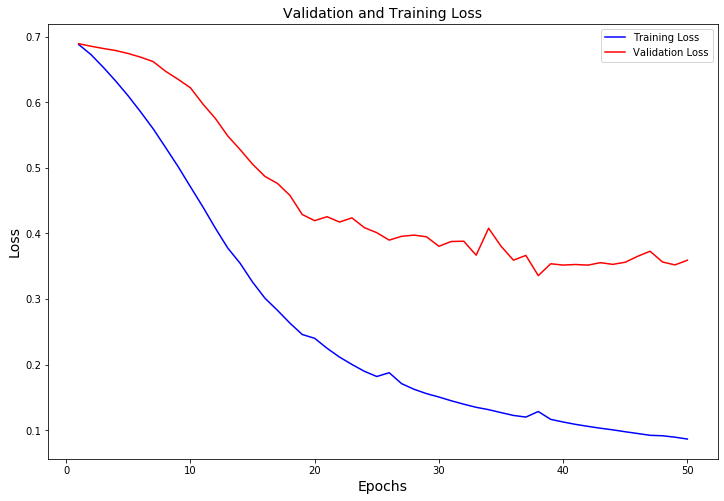

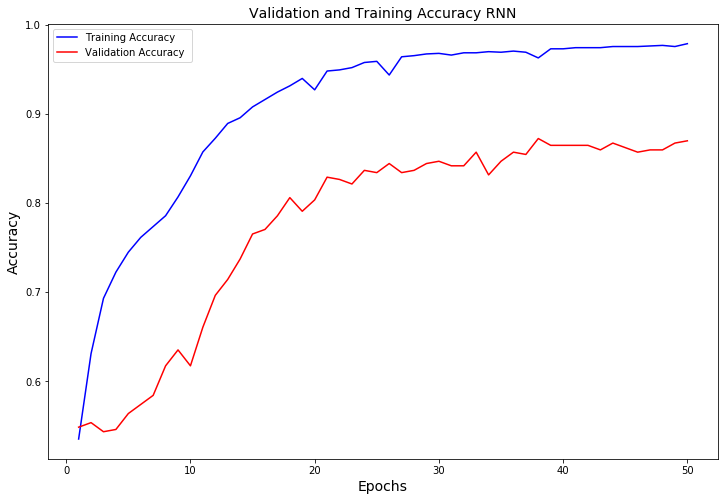

In [20]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['loss'], 'b', label='Training Loss')
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['val_loss'], 'b', label='Validation Loss' , color='red')
ax.set_title('Validation and Training Loss',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Loss',fontsize=14)
ax.legend();

fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['accuracy'], 'b', label='Training Accuracy ')
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['val_accuracy'], 'b', label='Validation Accuracy ' , color='red')
ax.set_title('Validation and Training Accuracy RNN',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.legend();

### LSTM layer

We can use a LSTM model to classify our texts.

[LSTM is a more powerful recurrent unit](https://jamboard.google.com/d/15OoyC0asnv5ng7u3invLEHYgavLhdGLiWpi5aqIlPfI/edit?usp=sharing) to take into account long range dependencies in our sequential data. 

In [21]:
def LSTMmodel(max_len,max_words,dim_embedding):
    model = Sequential()
    model.add(Embedding(max_words,dim_embedding,input_length=max_len, name='features'))
    model.add(LSTM(15))
    model.add(Dense(15, activation='relu',name='FC1'))
    model.add(Dropout(0.5)) # add a dropout to reduce overfitting
    model.add(Dense(1, activation='sigmoid',name='out_layer'))
    return model

In [22]:
lstm = LSTMmodel(max_len,max_words,dim_embedding = 20)
opt = Adam(lr=0.0001)
lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (Embedding)         (None, 150, 20)           20000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                2160      
_________________________________________________________________
FC1 (Dense)                  (None, 15)                240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 16        
Total params: 22,416
Trainable params: 22,416
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_lstm = lstm.fit(sequences_matrix, classes, epochs=50,batch_size=32, validation_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1564 samples, validate on 392 samples
Epoch 1/50
1564/1564 [==============================] - 8s 5ms/step - loss: 0.6924 - accuracy: 0.5652 - val_loss: 0.6921 - val_accuracy: 0.6122
Epoch 2/50
1564/1564 [==============================] - 7s 5ms/step - loss: 0.6903 - accuracy: 0.6419 - val_loss: 0.6911 - val_accuracy: 0.6071
Epoch 3/50
1564/1564 [==============================] - 7s 4ms/step - loss: 0.6879 - accuracy: 0.6918 - val_loss: 0.6894 - val_accuracy: 0.6173
Epoch 4/50
1564/1564 [==============================] - 7s 4ms/step - loss: 0.6832 - accuracy: 0.7385 - val_loss: 0.6865 - val_accuracy: 0.6454
Epoch 5/50
1564/1564 [==============================] - 7s 5ms/step - loss: 0.6755 - accuracy: 0.7903 - val_loss: 0.6815 - val_accuracy: 0.6735
Epoch 6/50
1564/1564 [==============================] - 7s 4ms/step - loss: 0.6638 - accuracy: 0.8056 - val_loss: 0.6738 - val_accuracy: 0.6811
Epoch 7/50
1564/1564 [==============================] - 7s 4ms/step - loss: 0.6448 - accu

#### Accuracy and Loss plots

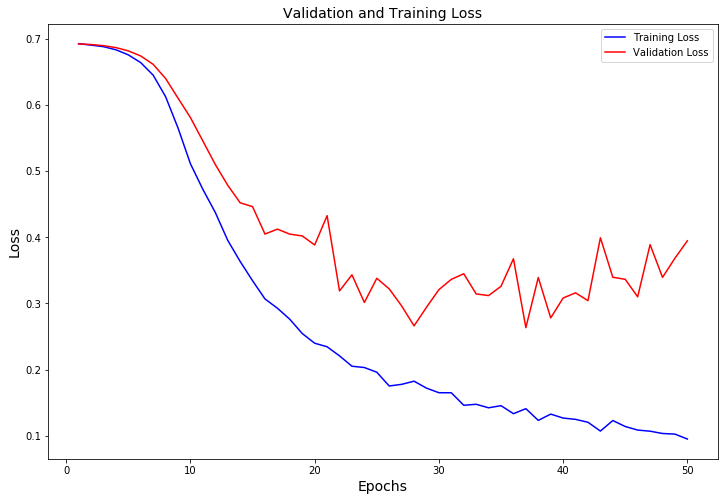

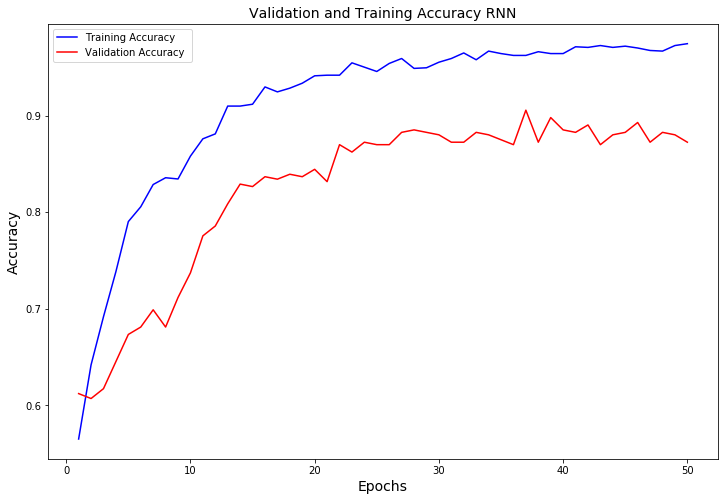

In [24]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['loss'], 'b', label='Training Loss')
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['val_loss'], 'b', label='Validation Loss' , color='red')
ax.set_title('Validation and Training Loss',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Loss',fontsize=14)
ax.legend();

fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['accuracy'], 'b', label='Training Accuracy ')
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['val_accuracy'], 'b', label='Validation Accuracy ' , color='red')
ax.set_title('Validation and Training Accuracy RNN',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.legend();

#### Comparison plots

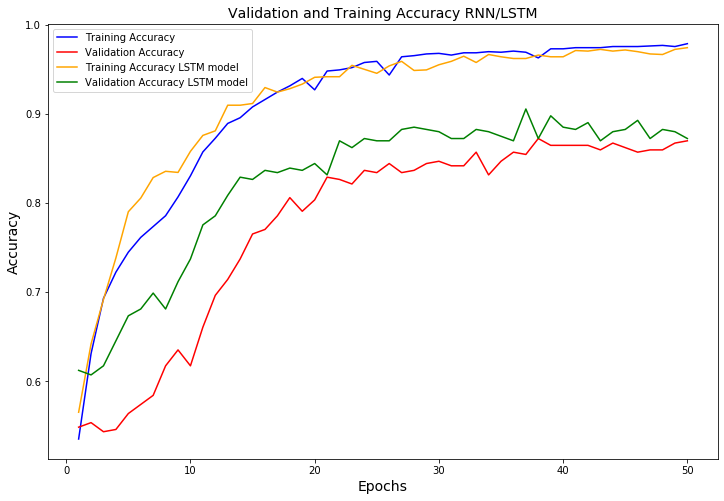

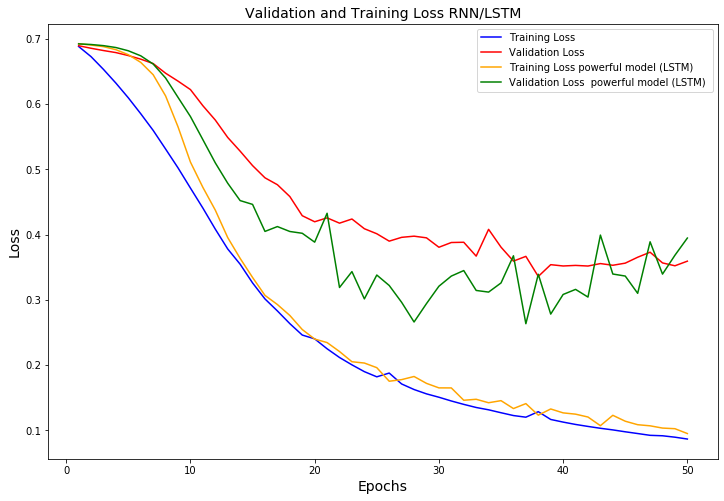

In [25]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca()
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['accuracy'], 'b', label='Training Accuracy ')
ax.plot(range(1,len(history.history['accuracy'])+1), history.history['val_accuracy'], 'b', label='Validation Accuracy ' , color='red')
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['accuracy'], 'b', label='Training Accuracy LSTM model', color='orange')
ax.plot(range(1,len(history_lstm.history['accuracy'])+1), history_lstm.history['val_accuracy'], 'b', label='Validation Accuracy LSTM model' , color='green')

ax.set_title('Validation and Training Accuracy RNN/LSTM',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.legend();

fig = plt.figure(figsize=(12,8))

ax = plt.gca()
ax.plot(range(1,len(history.history['loss'])+1), history.history['loss'], 'b', label='Training Loss ')
ax.plot(range(1,len(history.history['loss'])+1), history.history['val_loss'], 'b', label='Validation Loss ' , color='red')
ax.plot(range(1,len(history_lstm.history['loss'])+1), history_lstm.history['loss'], 'b', label='Training Loss powerful model (LSTM)', color='orange')
ax.plot(range(1,len(history_lstm.history['loss'])+1), history_lstm.history['val_loss'], 'b', label='Validation Loss  powerful model (LSTM) ' , color='green')

ax.set_title('Validation and Training Loss RNN/LSTM',fontsize=14)
ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Loss',fontsize=14)
ax.legend();

## Conclusions

In this case we have short texts: no need for LSTM.
In general a more complicated model (more parameters) means likely to overfit.

### Exercises ###

* Operate a train test split and `predict` the Rnn/LSTM output.
* Feel free to play with parameters and modify the models above to fight overfit (adding dropout, less layers, reducing the batch size)
* Try to build a basic model using only `Dense` layers and study performances.